# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns


In [3]:
workdir='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/'
datadir='//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/'
outdir='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/butane.pdb
//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295271861905623 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,34.26150597396067,342.483160991024
2000,53.088455238266505,399.26684429811905


In [6]:
os.path.join(workdir, "butane_sim.dcd")

'/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/butane_sim.dcd'

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,38.927706288245126,231.75926218276655,0
500000,999.9999999901769,39.985288572096735,401.0341858817605,1.77e+04
750000,1499.9999999783536,66.16333861235198,325.34367778642655,1.79e+04
1000000,1999.9999999665301,33.70845487910829,315.64369130301935,1.8e+04
1250000,2499.9999999547067,43.33230433710624,453.8714301175206,1.8e+04
1500000,2999.9999999428833,30.394651438366882,363.99568780791685,1.81e+04
1750000,3499.99999993106,37.105208419471836,195.54430179117003,1.82e+04
2000000,3999.9999999192364,32.00627865901536,163.29984658055196,1.82e+04
2250000,4499.9999999992715,45.875094298216126,243.92254619453976,1.82e+04
2500000,5000.000000101135,41.62980594867015,232.69599185264508,1.83e+04
2750000,5500.000000202998,39.14626131957332,301.636891968814,1.84e+04
3000000,6000.000000304862,43.608800282389595,303.95645504812904,1.84e+04
3250000,6500.000000406725,30.096610

In [5]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x13d0b2150>

In [6]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [7]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x1391e12d0>

In [8]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [9]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


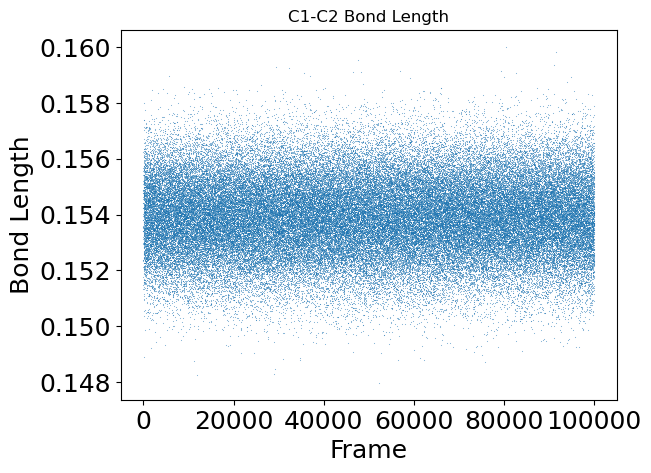

In [10]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000])

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

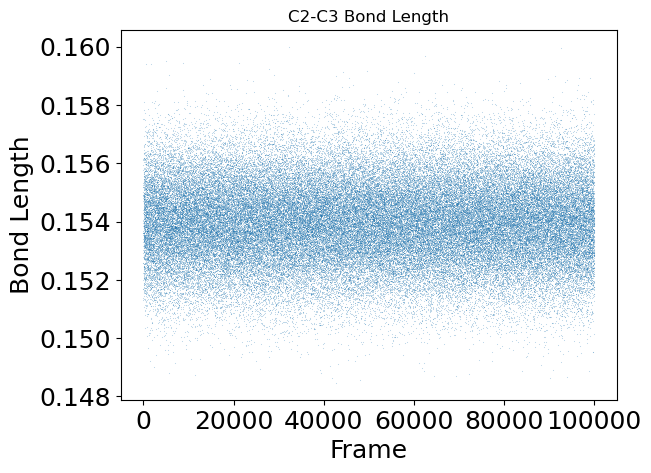

In [11]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

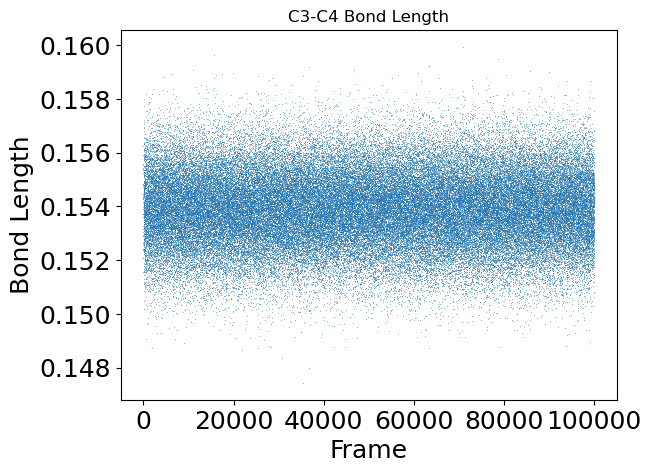

In [12]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

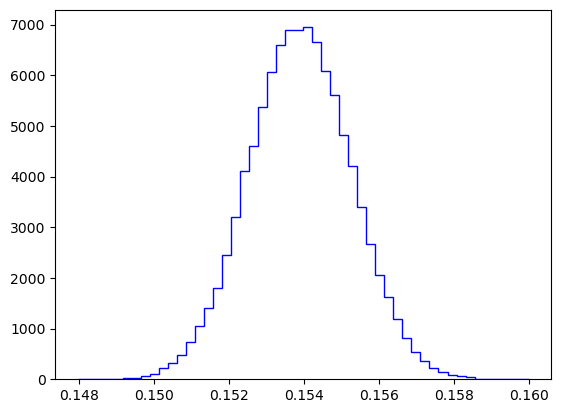

In [13]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

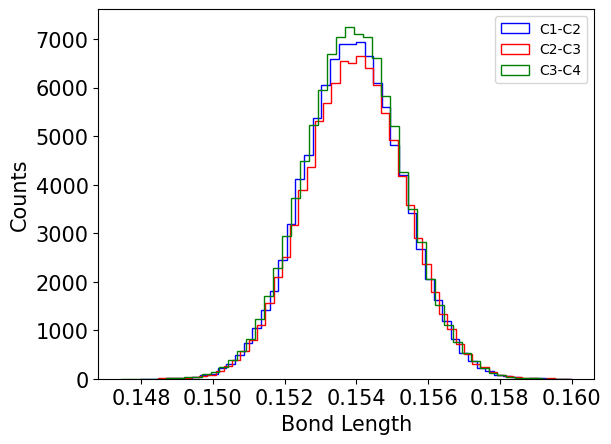

In [14]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

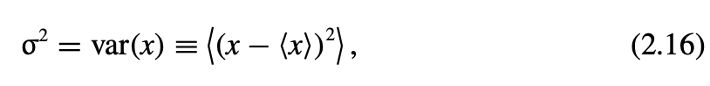

In [14]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [15]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 1.866589e-06 C1-C2 standard deviation: 0.0013662316588454243
C2-C3 variance: 1.9081338e-06 C1-C2 standard deviation: 0.0013813521470334078
C3-C4 variance: 1.9081338e-06 C1-C2 standard deviation: 0.0013680864429787619


In [16]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15390547 variance: 1.866589e-06 std-dev: 0.0013662317
C2-C3 average: 0.1539542 variance: 1.9081338e-06 std-dev: 0.0013813522
C3-C4 average: 0.15390472 variance: 1.8716605e-06 std-dev: 0.0013680864


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [17]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: LinregressResult(slope=-0.1035633524616166, intercept=0.16989315903775337, rvalue=-0.10242973465084784, pvalue=2.314497638854468e-231, stderr=0.0031804903601245723, intercept_stderr=0.0004895141379734321)


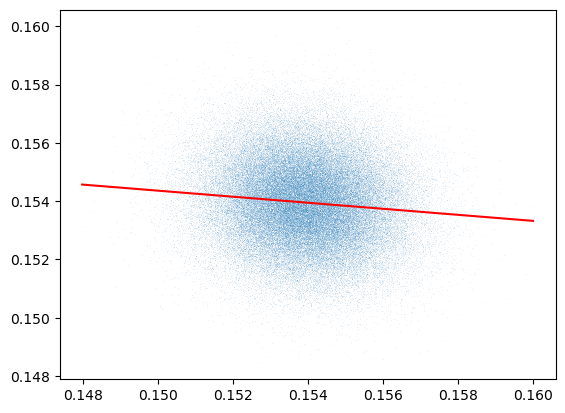

r2: -0.10242973465084784
Line Parameters: LinregressResult(slope=0.01692690154304908, intercept=0.1512995784675753, rvalue=0.016903954019961476, pvalue=9.001125147700872e-08, stderr=0.0031661497435552873, intercept_stderr=0.00048730695173387185)


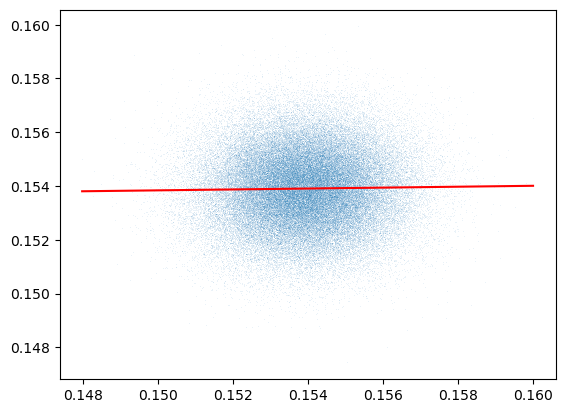

r2: 0.016903954019961476


In [18]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=scipy.stats.linregress(C1C2bondlength[:,0],C2C3bondlength[:,0])
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=scipy.stats.linregress(C1C2bondlength[:,0],C3C4bondlength[:,0])
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

<Figure size 640x480 with 0 Axes>

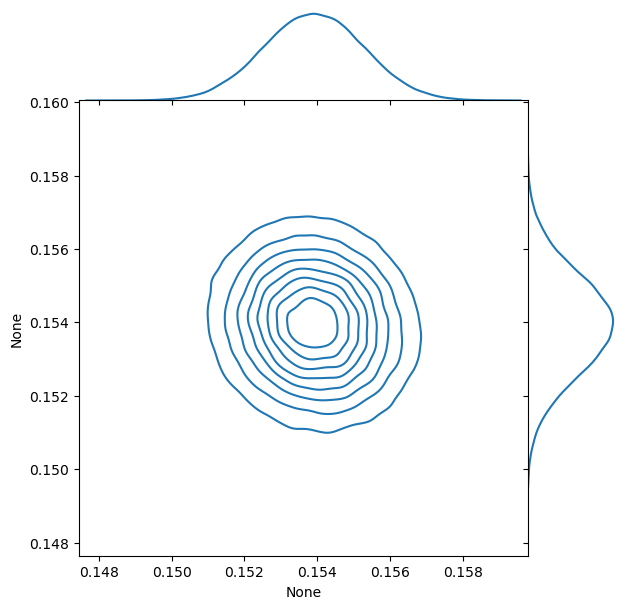

In [19]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

<Figure size 640x480 with 0 Axes>

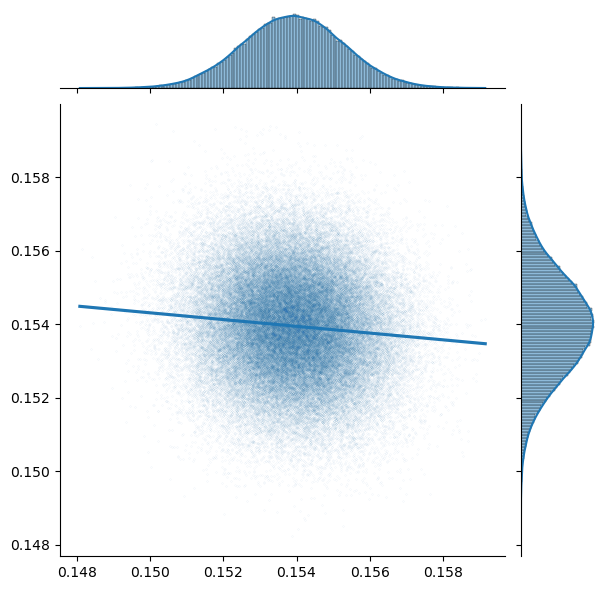

In [20]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

HERE IS MY ANSWER:

The C1-C2 and C2-C3 bond lengths are slightly more inversely correlated as compared to C1-C2 and C3-C4, this is because C1-C2 and C2-C3 bonds are bonded to the same atom and thus when both are shorter, there will be more repulsion between C1-C3 atoms, so they try to avoid each other so that when one is shorter, it is energetically more favorable for the other one to stay longer

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

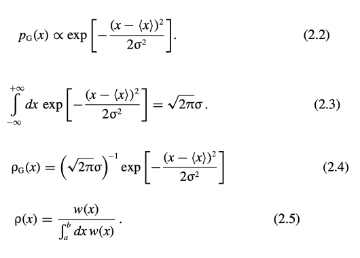
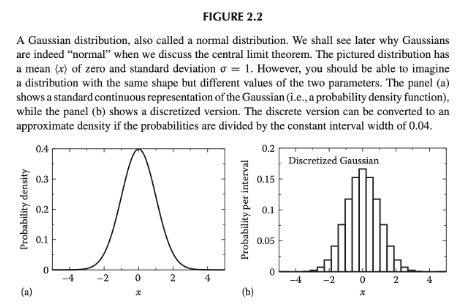

[    0     3    10    56   275  1038  2865  6192 11546 16498 18728 17175
 12668  7443  3627  1349   405   104    15     2] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.18808125245119825 x_0: 0.1538995365879515 fit_sigma: -0.00137867186962204


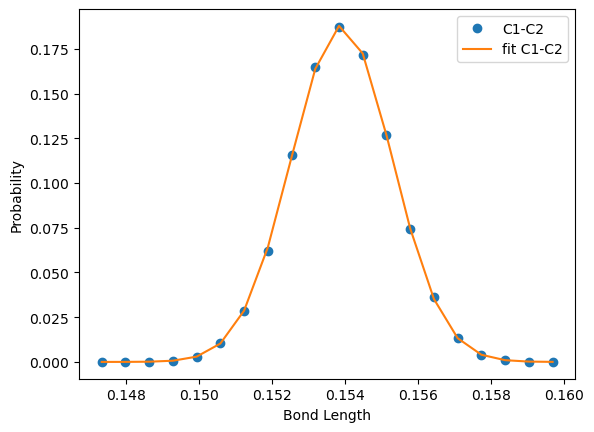

In [18]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

[    0     0    17    53   264   979  2749  6186 10919 16007 18488 17335
 13068  7894  3880  1521   489   120    23     8] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]

For the bond C2C3 the following parameters were obtained - a: 0.18598098229949572 x_0: 0.15395221340446424 fit_sigma: -0.001394524017723321 

[    1     1    12    71   292  1041  2828  6406 11367 16259 18704 17422
 12713  7494  3485  1370   406   102    23     3] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]

For the bond C3C4 the following parameters were obtained - a: 0.18801749837027631 x_0: 0.1539083435970409 fit_sigma: 0.001378769450386706 



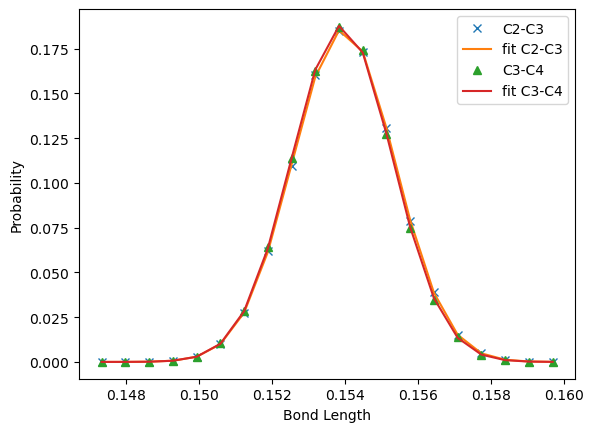

In [19]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

from scipy.optimize import curve_fit

####HOMEWORK SOLUTION####
def histogram_bincenters(BondLengths,NumberOfBins):
    counts, edges = np.histogram(BondLengths,bins=NumberOfBins,range=[0.147,0.160])
    print(counts,edges)
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
####ADD YOUR CODE HERE #####
    return centers,density 

def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(Name,x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("\nFor the bond",Name,"the following parameters were obtained - a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma,"\n")
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]

#USE THE FUNCTION TO ITERATE OVER ALL CC BONDS, plot the densities and the fits 

C2C3Centers,C2C3density = histogram_bincenters(C2C3bondlength[:,0],20)
C2C3_fit,C2C3_fit_params=fit_gauss('C2C3',C2C3Centers,C2C3density)

plt.plot(C2C3Centers,C2C3density,'x',label='C2-C3')
plt.plot(C2C3Centers,C2C3_fit,'-',label='fit C2-C3')

C3C4Centers,C3C4density = histogram_bincenters(C3C4bondlength[:,0],20)
C3C4_fit,C3C4_fit_params=fit_gauss('C3C4',C3C4Centers,C3C4density)

plt.plot(C3C4Centers,C3C4density,'^',label='C3-C4')
plt.plot(C3C4Centers,C3C4_fit,'-',label='fit C3-C4')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

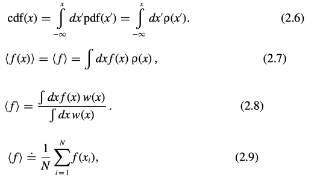

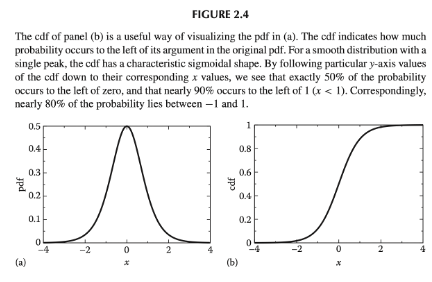

[    0     3    10    56   275  1038  2865  6192 11546 16498 18728 17175
 12668  7443  3627  1349   405   104    15     2] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]

For the bond C1C2 the following parameters were obtained - a: 0.18808125245119825 x_0: 0.1538995365879515 fit_sigma: -0.00137867186962204 

[    0     0    17    53   264   979  2749  6186 10919 16007 18488 17335
 13068  7894  3880  1521   489   120    23     8] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]

For the bond C2C3 the following parameters were obtained - a: 0.18598098229949572 x_0: 0.15395221340446424 fit_sigma: -0.001394524017723321 

[    1     1    12    71   292  1041  2828  6406 11367 16259 18704 17422
 12713  7494  3485  1370   406   102    23     3] [0.14

Text(0, 0.5, 'Cumulative Probability')

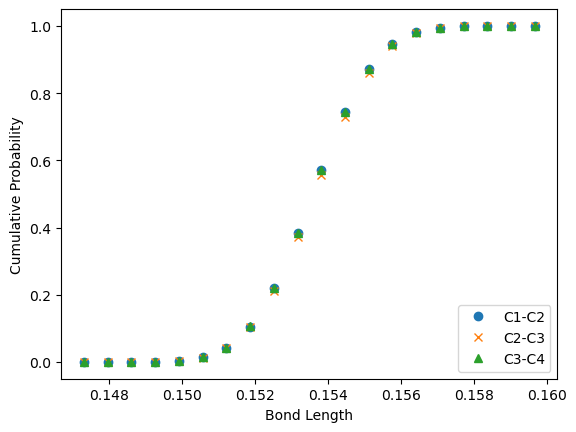

In [20]:
from scipy.optimize import curve_fit

def histogram_bincenters(BondLengths,NumberOfBins):
    counts, edges = np.histogram(BondLengths,bins=NumberOfBins,range=[0.147,0.160])
    print(counts,edges)
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    return centers,density 

def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(Name,x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("\nFor the bond",Name,"the following parameters were obtained - a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma,"\n")
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2Centers,C1C2density = histogram_bincenters(C1C2bondlength[:,0],20)
C1C2_fit,C1C2_fit_params=fit_gauss('C1C2',C1C2Centers,C1C2density)

C2C3Centers,C2C3density = histogram_bincenters(C2C3bondlength[:,0],20)
C2C3_fit,C2C3_fit_params=fit_gauss('C2C3',C2C3Centers,C2C3density)

C3C4Centers,C3C4density = histogram_bincenters(C3C4bondlength[:,0],20)
C3C4_fit,C3C4_fit_params=fit_gauss('C3C4',C3C4Centers,C3C4density)

###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#TRY THIS FUNCTION:
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
#ADD CODE FOR CDFs HERE#
C1C2_Cumulative=np.cumsum(C1C2density)
C2C3_Cumulative=np.cumsum(C2C3density)
C3C4_Cumulative=np.cumsum(C3C4density)
plt.plot(C1C2Centers,C1C2_Cumulative,'o',label='C1-C2')
plt.plot(C2C3Centers,C2C3_Cumulative,'x',label='C2-C3')
plt.plot(C3C4Centers,C3C4_Cumulative,'^',label='C3-C4')
plt.legend(loc = 'lower right')
plt.xlabel('Bond Length')
plt.ylabel('Cumulative Probability')


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle.  Why is the Gaussian fit for a dihedral so poor with a large sample? ***


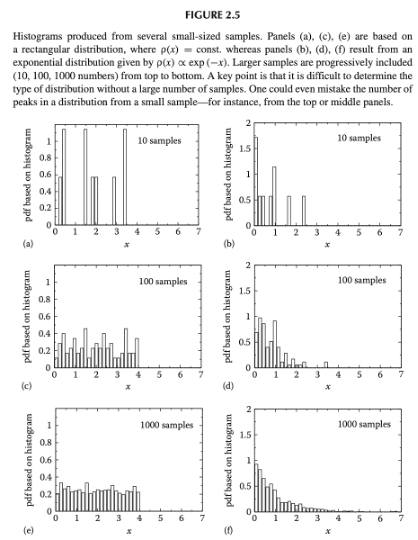


Following number of counts and their corresponding edges were obtained for C1C2bondlength  with  10  samples:
 [0 0 0 0 0 1 1 1 0 1 2 0 1 0 3 0 0 0 0 0] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ] 


Covariance for a sample size of 10 for C1C2bondlength is

 [[ 1.24724765e-03 -2.68215275e-07  2.16167843e-05]
 [-2.68215275e-07  1.05013127e-06 -1.65543543e-08]
 [ 2.16167843e-05 -1.65543543e-08  1.09763504e-06]] 


Following number of counts and their corresponding edges were obtained for C1C2bondlength  with  100  samples:
 [ 0  0  0  0  0  0  2  4  8 14 22 18 17  9  2  2  2  0  0  0] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ] 


Covariance for a sample size of 100 for C1C2bondlength is

 [[ 5.37462023e-05  2.89260663e-13 -2.09492548e-0

<function matplotlib.pyplot.show(close=None, block=None)>

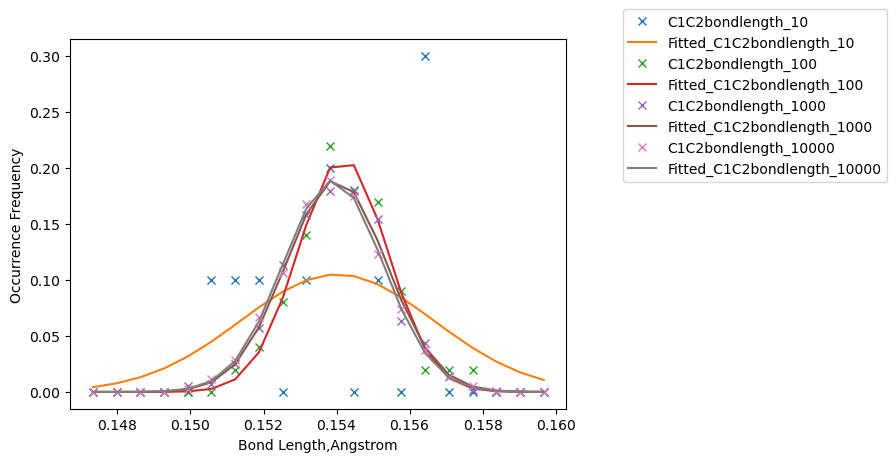

In [21]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

#This function might be helpful:
rands=np.random.randint(100000, size=(10))
#rands
C1C2bond=C1C2bondlength[:,0]
#C1C2bond[rands]
#plt.hist(C1C2bond[rands],bins=20,histtype='step')

from scipy.optimize import curve_fit

def FitToGaussianAndPlot(Name,InputValues,NumberOfSamples,LowerBound,UpperBound):
    rands=np.random.randint(100000, size=(NumberOfSamples))
    Values = InputValues[rands]
    counts, edges = np.histogram(Values,bins=20,range=[LowerBound,UpperBound])
    print("\nFollowing number of counts and their corresponding edges were obtained for", Name, " with ",str(NumberOfSamples)," samples:\n",counts,edges,"\n")
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    params, covar =curve_fit(gauss,centers,density)
    FittedValues = params[0]*np.exp(-(centers-params[1])**2/(2*params[2]**2))
    PlotName = Name+'_'+str(NumberOfSamples)
    plt.plot(centers, density, 'x',label=PlotName)
    plt.plot(centers, FittedValues,'-',label='Fitted_'+PlotName)
    return covar

covar_10 = FitToGaussianAndPlot('C1C2bondlength',C1C2bondlength,10,0.147,0.16)
print("\nCovariance for a sample size of 10 for C1C2bondlength is\n\n",covar_10,"\n")

covar_100 = FitToGaussianAndPlot('C1C2bondlength',C1C2bondlength,100,0.147,0.16)
print("\nCovariance for a sample size of 100 for C1C2bondlength is\n\n",covar_100,"\n")

covar_1000 = FitToGaussianAndPlot('C1C2bondlength',C1C2bondlength,1000,0.147,0.16)
print("\nCovariance for a sample size of 1000 for C1C2bondlength is\n\n",covar_1000,"\n")

covar_10000 = FitToGaussianAndPlot('C1C2bondlength',C1C2bondlength,10000,0.147,0.16)
print("\nCovariance for a sample size of 10000 for C1C2bondlength is\n\n",covar_10000,"\n")

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.xlabel('Bond Length,Angstrom')
plt.ylabel('Occurrence Frequency')
plt.show

#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?

#CONTINUED IN THE NEXT CELL


Following number of counts and their corresponding edges were obtained for CCCC_torsion  with  10  samples:
 [2 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 2 3] [-3.1416  -2.82744 -2.51328 -2.19912 -1.88496 -1.5708  -1.25664 -0.94248
 -0.62832 -0.31416  0.       0.31416  0.62832  0.94248  1.25664  1.5708
  1.88496  2.19912  2.51328  2.82744  3.1416 ] 


Covariance for a sample size of 10 for CCCC_torsion is

 [[ 1.68523780e+04 -3.91973085e+02  1.37350343e+03]
 [-3.91973085e+02  9.11719411e+00 -3.19465965e+01]
 [ 1.37350343e+03 -3.19465965e+01  1.11943457e+02]] 


Following number of counts and their corresponding edges were obtained for CCCC_torsion  with  100  samples:
 [29  3  1  0  1  2  3  3  0  0  0  0  3  1  4  0  0  0  7 43] [-3.1416  -2.82744 -2.51328 -2.19912 -1.88496 -1.5708  -1.25664 -0.94248
 -0.62832 -0.31416  0.       0.31416  0.62832  0.94248  1.25664  1.5708
  1.88496  2.19912  2.51328  2.82744  3.1416 ] 


Covariance for a sample size of 100 for CCCC_torsion is

 [[ 1707.699767

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

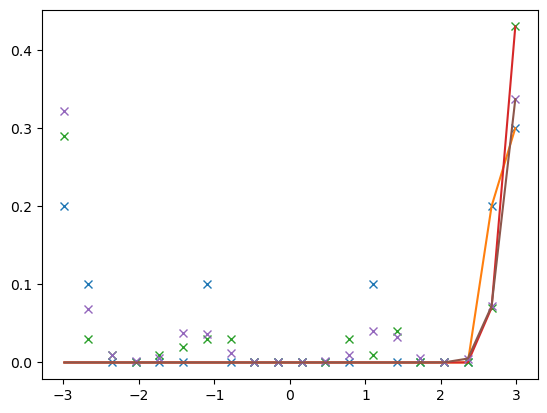

In [22]:
from scipy.optimize import curve_fit

def FitToGaussianAndPlot(Name,InputValues,NumberOfSamples,LowerBound,UpperBound):
    rands=np.random.randint(100000, size=(NumberOfSamples))
    Values = InputValues[rands]
    counts, edges = np.histogram(Values,bins=20,range=[LowerBound,UpperBound])
    print("\nFollowing number of counts and their corresponding edges were obtained for", Name, " with ",str(NumberOfSamples)," samples:\n",counts,edges,"\n")
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/(np.sum(counts))
    params, covar =curve_fit(gauss,centers,density)
    FittedValues = params[0]*np.exp(-(centers-params[1])**2/(2*params[2]**2))
    PlotName = Name+'_'+str(NumberOfSamples)
    plt.plot(centers, density, 'x',label=PlotName)
    plt.plot(centers, FittedValues,'-',label='Fitted_'+PlotName)
    return covar

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

covar_10 = FitToGaussianAndPlot('CCCC_torsion',CCCC_torsion,10,-3.1416,3.1416)
print("\nCovariance for a sample size of 10 for CCCC_torsion is\n\n",covar_10,"\n")

covar_100 = FitToGaussianAndPlot('CCCC_torsion',CCCC_torsion,100,-3.1416,3.1416)
print("\nCovariance for a sample size of 100 for CCCC_torsion is\n\n",covar_100,"\n")

covar_1000 = FitToGaussianAndPlot('CCCC_torsion',CCCC_torsion,1000,-3.1416,3.1416)
print("\nCovariance for a sample size of 1000 for CCCC_torsion is\n\n",covar_1000,"\n")

covar_10000 = FitToGaussianAndPlot('CCCC_torsion',C1C2bondlength,10000,-3.1416,3.1416)
print("\nCovariance for a sample size of 10000 for CCCC_torsion is\n\n",covar_10000,"\n")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Torsional Angle,rad')
plt.ylabel('Occurrence Frequency')
plt.show

#I tried running this and the curve_fit gives an error that Optimal parameters not found: 
#Number of calls to function has reached maxfev = 800.
#I think this is the problem of python numerical instability and wrong type of curve fitting, 
#because we expect three basins for a torsion, not a gaussian, so the function should not fit well

In [23]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.8707082 1.9719868]
 [1.9122369 1.9564021]
 [2.0532367 2.0752168]
 ...
 [2.0461466 2.0462224]
 [1.9118198 2.0028503]
 [1.9663583 1.8600347]]


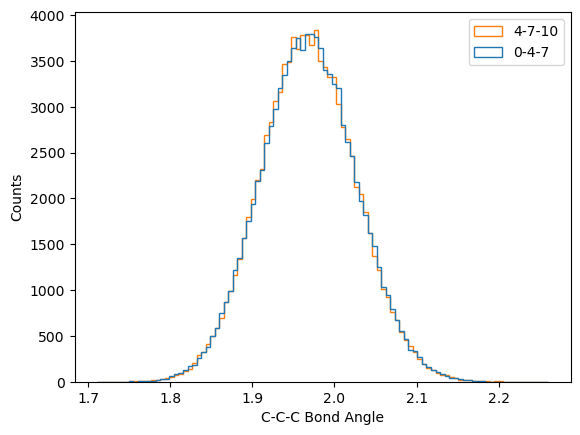

[[-2.8952787 ]
 [-2.7526512 ]
 [-3.024192  ]
 ...
 [ 1.2883432 ]
 [ 0.78208065]
 [ 1.599461  ]]
[[-165.88724 ]
 [-157.71529 ]
 [-173.27344 ]
 ...
 [  73.81662 ]
 [  44.809917]
 [  91.64236 ]]


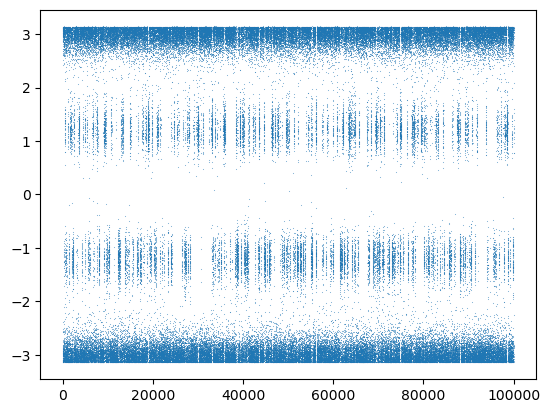

In [19]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

(0.0, 1000.0)

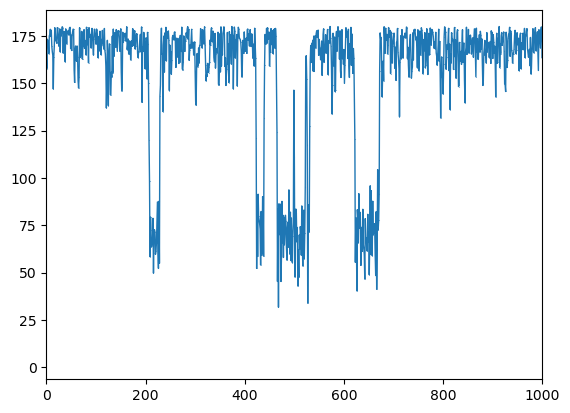

In [20]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [21]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)

#Probability of being between 0 and -2 radians:
print(len(CCCC_dihe[c])/len(CCCC_dihe))


(array([    0,     1,     2, ..., 99980, 99983, 99985]),)
[-2.8952787 -2.7526512 -3.024192  ... -2.9821844 -3.0220134 -2.2555773]
(array([    3,     6,     7, ..., 99997, 99998, 99999]),)
(array([  208,   209,   210, ..., 99855, 99856, 99857]),)
0.10827


Probability to be found in either of the two higher energy basins is  0.19929199291992905 



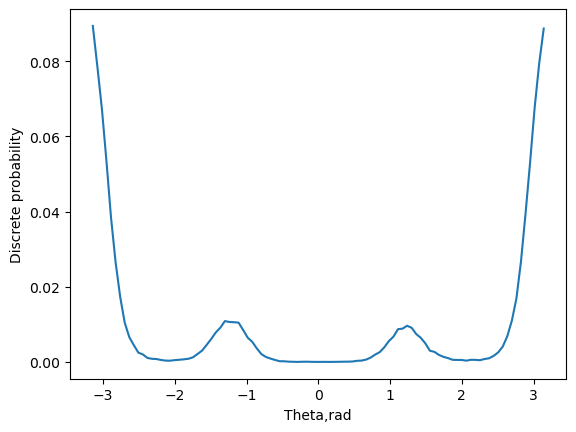

In [58]:
CCCC_dihe=CCCC_torsion[:,0]
a = np.zeros(100)

for i in range(0,100):
    a[i] = len(CCCC_dihe[np.where((CCCC_dihe < np.pi*((i+1)/50-1)) & (CCCC_dihe>np.pi*(i/50-1)))])
b = a/np.sum(a)
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x,b)
plt.xlabel('Theta,rad')
plt.ylabel('Discrete probability')
plt.show

c = np.cumsum(b)

prob = c[84]-c[58]+c[42]-c[16]
print("Probability to be found in either of the two higher energy basins is ",prob,"\n")

**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: -0.008851475584850018


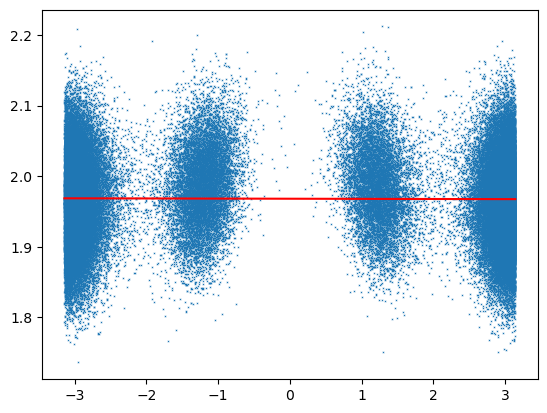

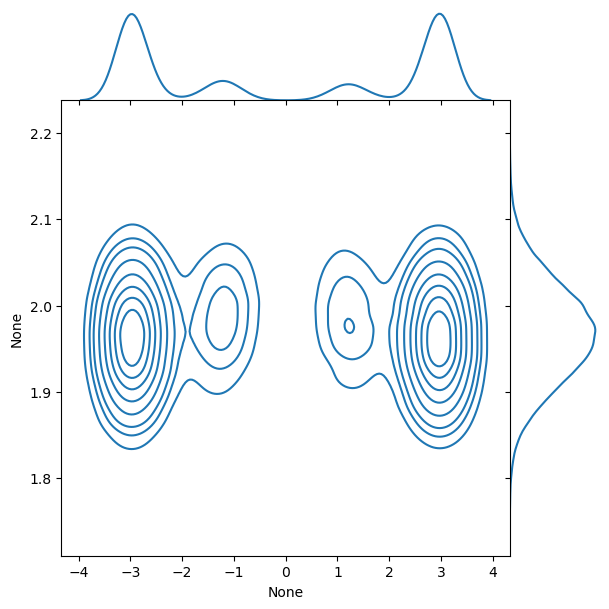

In [27]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
import seaborn as sns
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

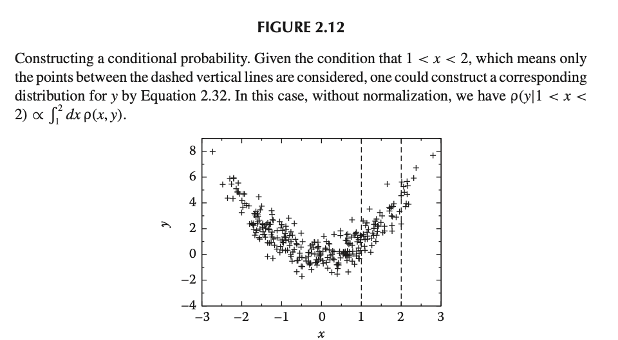

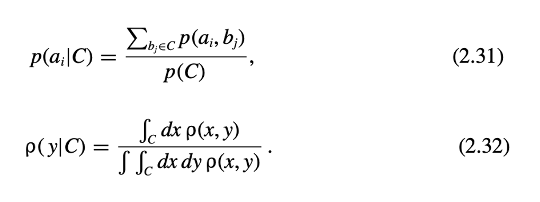

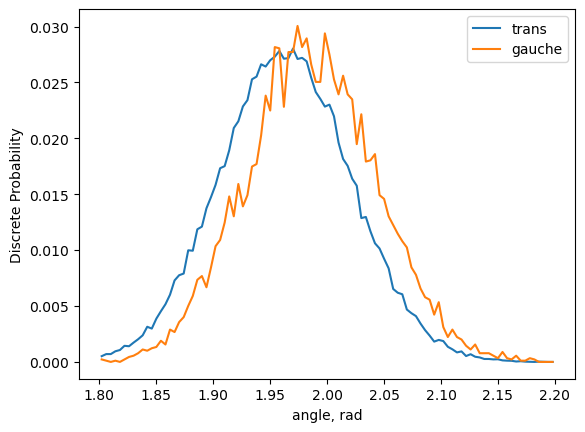

In [72]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html


#As we can see, when the butane is in the gauch conformation, we have, on average, higher bond angle, which makes sense
#as the two methyl groups try to move apart

CCCC_dihe_absolute = np.zeros(len(CCCC_dihe))

for i in range(0,len(CCCC_dihe)):
    if(CCCC_dihe[i] < 0):
        CCCC_dihe_absolute[i] = CCCC_dihe[i] + 2*np.pi
    else:
        CCCC_dihe_absolute[i] = CCCC_dihe[i]
        
a = np.where((CCCC_dihe_absolute > 2) & (CCCC_dihe_absolute < 4))
b = np.where((CCCC_dihe_absolute > 0) & (CCCC_dihe_absolute < 2))

counts_trans, edges_trans = np.histogram(ang1[a],bins=100,range=[1.8,2.2])
counts_gauche, edges_gauche = np.histogram(ang1[b],bins=100,range=[1.8,2.2])

centers_trans = edges_trans[:-1] + np.diff(edges_trans)/2
density_trans = counts_trans/np.sum(counts_trans)
centers_gauche = edges_gauche[:-1] + np.diff(edges_gauche)/2
density_gauche = counts_gauche/np.sum(counts_gauche)

plt.plot(centers_trans, density_trans, '-',label='trans')
plt.plot(centers_gauche, density_gauche, '-',label='gauche')
plt.xlabel('angle, rad')
plt.ylabel('Discrete Probability')
plt.legend(loc = 'upper right')

In [81]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.8707082 1.9122369 2.0532367 ... 2.0461466 1.9118198 1.9663583]
[1.9122369 2.0532367 2.044707  ... 2.0461466 1.9118198 1.9663583]
[1.8707082 1.9122369 2.0532367 ... 1.9372443 2.0461466 1.9118198]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


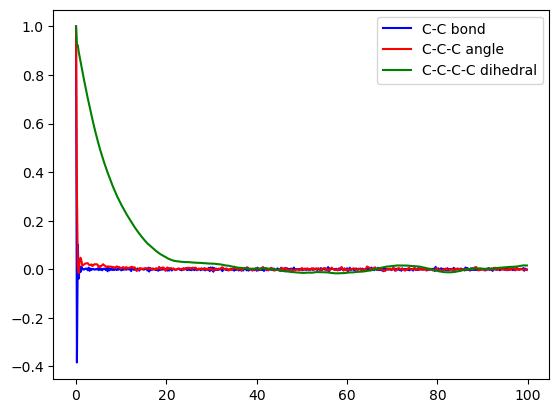

In [82]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

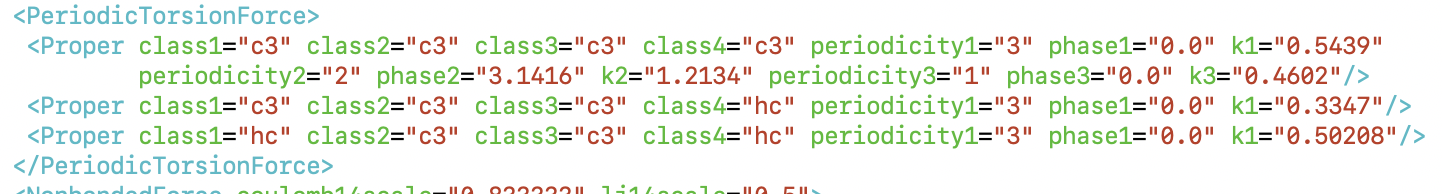

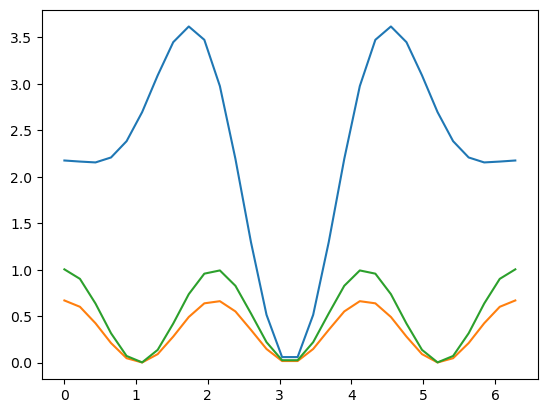

In [28]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.5439,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

In [29]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [30]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


In [31]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[-2.9455788  -0.87931323  1.3566197  ... -0.9343699   1.0576489
  -3.0038092 ]
 [-2.9229574  -0.8001239   1.369219   ... -1.5112798   0.75266314
   2.6287162 ]
 [-3.0832076  -1.0060918   1.1972547  ... -1.0118029   1.0197384
   3.0837183 ]
 ...
 [ 1.0715044   3.134031   -0.7648873  ... -1.330284    0.6366507
   2.8189352 ]
 [ 0.60129344  2.689785   -1.2838261  ... -1.3083091   0.87325597
   2.7624996 ]
 [ 1.6159794  -2.6125169  -0.43050835 ... -0.9764562   1.1661557
   2.9234889 ]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

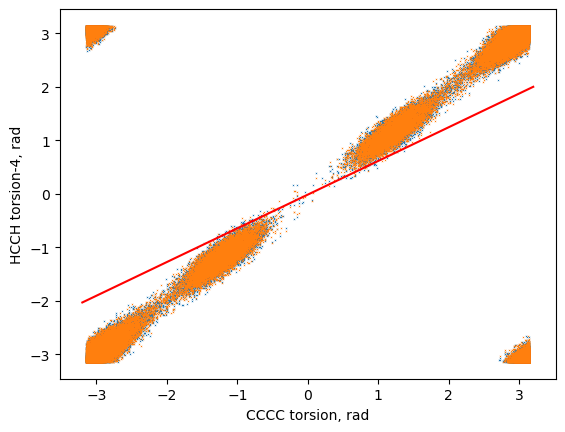

r^2 for CCCC and HCCH[:,3] is 0.632903741663011


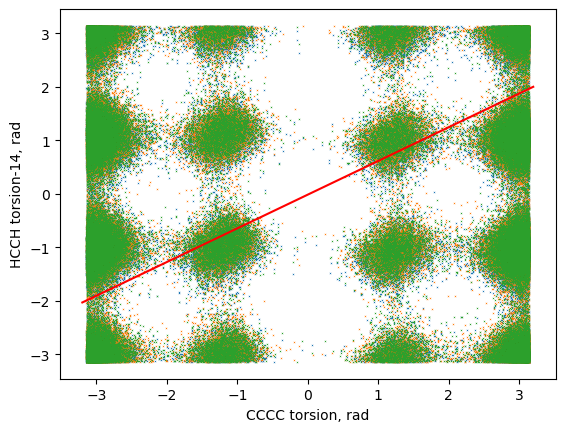

r^2 for CCCC and HCCH[:,13] is 0.019283474440950698


<Figure size 640x480 with 0 Axes>

In [63]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]

#CCCC vs. [8,7,4,5], CCCC vs. [9,7,4,6] and etc were chosen
#They are highly correlated because the end atoms are attached in the orientation to the central atoms
#This means that they will try their best to maintain their bond angles and the improper torsions, and as these two have very small range of
#fluctuations, due to the qunatum mechanical constraints put on the bond geometry, they are highly correlated as they usually maintain the
#tetrahedral geometry and have almost the same angles, with some deviations caused by small wiggling of atoms

#You can also see that there are basins of preferred torsions which correspond to the regions of the PES that are lower
plt.scatter(CCCC_torsion,HCCH_torsions[:,3],marker='x',s=0.05)
plt.scatter(CCCC_torsion,HCCH_torsions[:,0],marker='x',s=0.05)

y_fit1 = scipy.stats.linregress(CCCC_torsion[:,0],HCCH_torsions[:,3])
x1 = np.linspace(-3.2,3.2,20)
y1 = y_fit1[0]*x1 + y_fit1[1]
plt.plot(x1,y1,c='r',label='best fit line')
plt.xlabel('CCCC torsion, rad')
plt.ylabel('HCCH torsion-4, rad')
plt.show()
plt.clf()
r_1 = np.corrcoef(CCCC_torsion[:,0],HCCH_torsions[:,3])
print("r^2 for CCCC and HCCH[:,3] is", r_1[0,1])


#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

plt.scatter(CCCC_torsion,HCCH_torsions[:,13],marker='x',s=0.05)
plt.scatter(CCCC_torsion,HCCH_torsions[:,12],marker='x',s=0.05)
plt.scatter(CCCC_torsion,HCCH_torsions[:,11],marker='x',s=0.05)

y_fit2 = scipy.stats.linregress(CCCC_torsion[:,0],HCCH_torsions[:,13])
x2 = np.linspace(-3.2,3.2,20)
y2 = y_fit2[0]*x1 + y_fit2[1]
plt.plot(x1,y1,c='r',label='best fit line')
plt.xlabel('CCCC torsion, rad')
plt.ylabel('HCCH torsion-14, rad')
plt.show()
plt.clf()
r_2 = np.corrcoef(CCCC_torsion[:,0],HCCH_torsions[:,13])
print("r^2 for CCCC and HCCH[:,13] is", r_2[0,1])

#The plots show that there are low energy basins for the angles studied and the majority of time the butane spends there, but otherwise there
#is no correlation


**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

<function matplotlib.pyplot.show(close=None, block=None)>

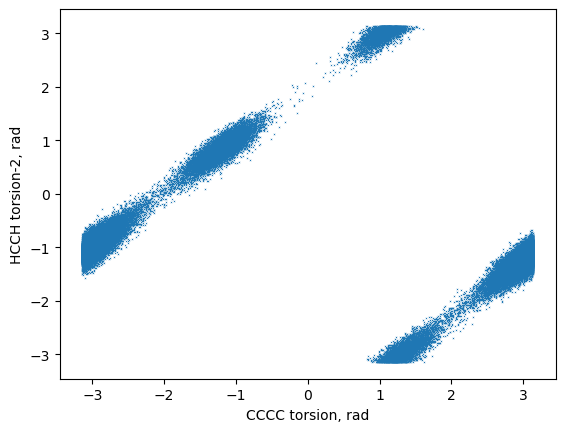

In [64]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT


plt.scatter(CCCC_torsion[:,0],HCCH_torsions[:,1],marker='x',s=0.05)
plt.xlabel('CCCC torsion, rad')
plt.ylabel('HCCH torsion-2, rad')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

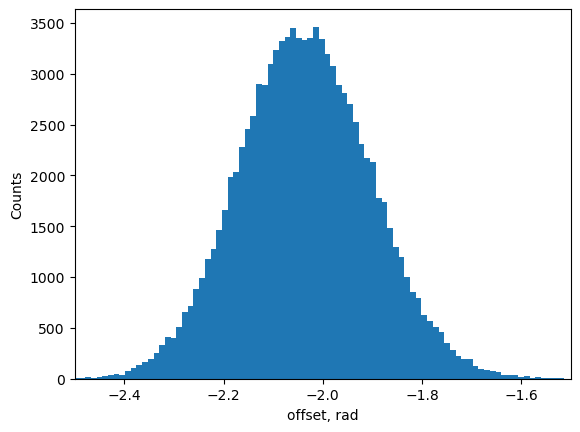

In [68]:
offset = CCCC_torsion[:,0] - HCCH_torsions[:,1]
a = np.where(offset > 0)
offset[a] = offset[a] - 2*np.pi
plt.hist(offset, bins = 100)
plt.xlim(-2.5,-1.5)
plt.xlabel('offset, rad')
plt.ylabel('Counts')
plt.show

#While previously chosen correlated angles had very similar value, the adjacent bonds have values shifter by 120 degrees either way,
#in this case it is shifted by -120 degrees or ~ -2.1 radians

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [ ]:
#I am not sure if it was supposed to be that easy, I just made k1 and k2 zero and that gave only the 3-periodic function that leaves equal
#three basins. I also tried implementing discrete sine transform (dst)-based decomposition of any function that is presented as a pair of
#angle-energy values and applied 11-order decomposition for the gaussian (see below)

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

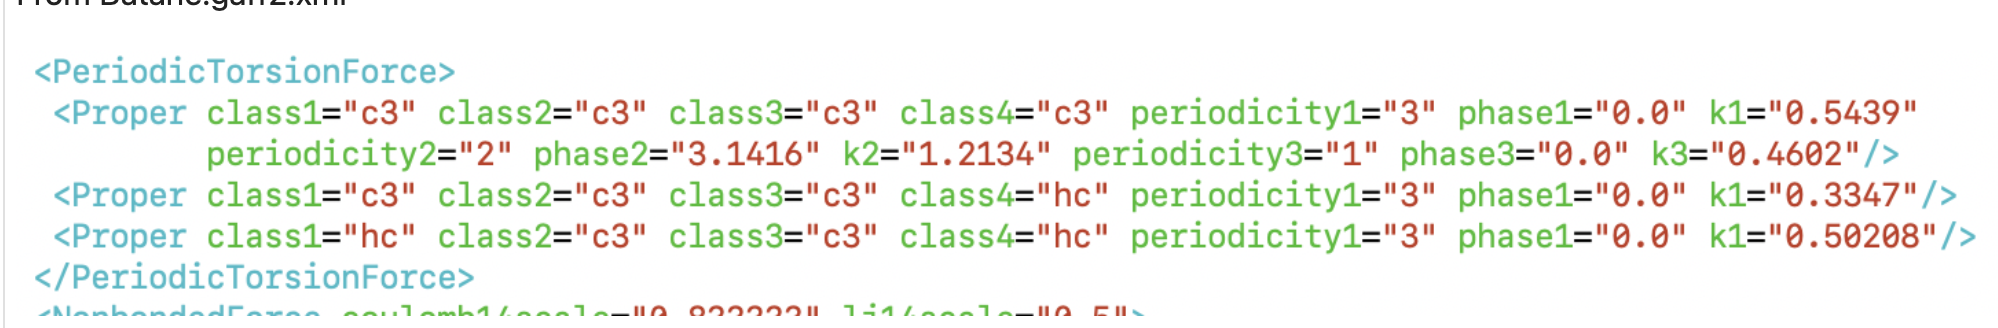

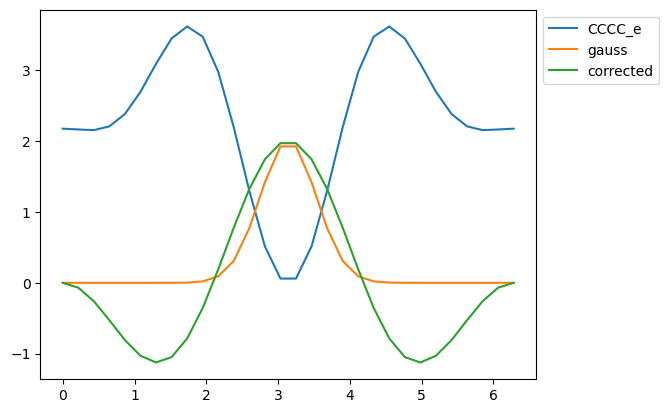

In [97]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang,CCCC_e, label = 'CCCC_e')

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang,gauss_cor, label = 'gauss')

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor=TorsionCorrection(rad_ang)

plt.plot(rad_ang,torsion_cor, label = 'corrected')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


The necessary correction coefficients that should be ADDED, not replace the current coefficients are:
k0 =  -5.337014794178139 
k1 =  -0.5744327078206167 
k2 =  1.0443518274638077 
k3 =  1.0837318752335472 



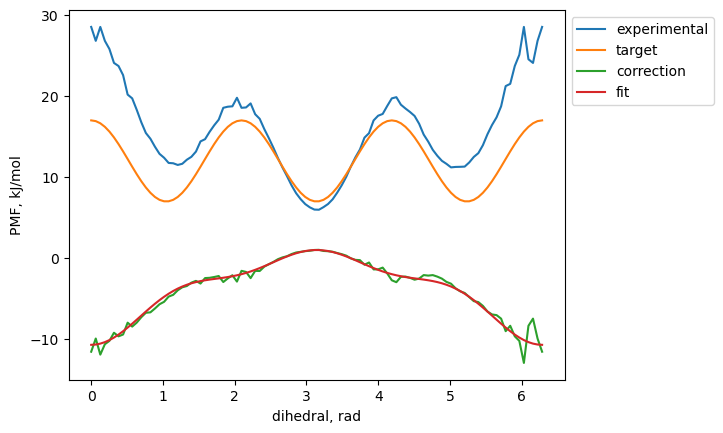

In [117]:
#Here a necessary correction to the PMF is calculated, then the necessary cosine coefficients are fitted

CCCC_dihe=CCCC_torsion[:,0]
CCCC_dihe_absolute = np.zeros(len(CCCC_dihe))
for i in range(0,len(CCCC_dihe)):
    if(CCCC_dihe[i] < 0):
        CCCC_dihe_absolute[i] = CCCC_dihe[i] + 2*np.pi
    else:
        CCCC_dihe_absolute[i] = CCCC_dihe[i]


a = np.zeros(100)
b = np.zeros(100)
for i in range(0,100):
    a[i] = len(CCCC_dihe_absolute[np.where((CCCC_dihe_absolute < np.pi*((i+1)/50)) & (CCCC_dihe_absolute>np.pi*(i/50)))])
    if(a[i] == 0):
        b[i] = 1
    else:
        b[i] = a[i]

b = b/np.sum(b)
PMF = -0.008314*298*np.log(b)
x = np.linspace(0, 2*np.pi, 100)
PMF_target = 5*np.cos(3*x)+12
plt.plot(x, PMF, label = 'experimental')
plt.plot(x, PMF_target, label  = 'target')
plt.xlabel('dihedral, rad')
plt.ylabel('PMF, kJ/mol')

PMF_correction = PMF_target-PMF

from scipy.optimize import curve_fit
def func(x1, k0, k1, k2, k3):
    return k0*(1-np.cos(x1-np.pi)) + k1*(1-np.cos(x1)) + k2*(1-np.cos(2*x1)) + k3*(1-np.cos(3*x1))
PMF_corr_coef, PMF_corr_cov = curve_fit(func, x, PMF_correction)

plt.plot(x, PMF_correction, label  = 'correction')
plt.plot(x, func(x, PMF_corr_coef[0], PMF_corr_coef[1], PMF_corr_coef[2], PMF_corr_coef[3]), label  = 'fit')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

print("The necessary correction coefficients that should be SUBTRACTED, not replaced the current coefficients are:\nk0 = ", PMF_corr_coef[0], "\nk1 = ", PMF_corr_coef[1],"\nk2 = ", PMF_corr_coef[2],"\nk3 = ", PMF_corr_coef[3],"\n")


#The XML file was modified to be as follows: <PeriodicTorsionForce>
#  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="-0.5398" 
#          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="1.0346" 
#          periodicity4="1" phase4="-3.1416" k4="5.337" periodicity5="2" phase5="0.0" k5="-1.044"/>
#  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
#  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>
#The values for ks were obtained from the fit, I subtracted the values from what was there before

***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [118]:
#RUN NEW MD SIMULATION HERE#
workdir='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/'
datadir='//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/'
outdir='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.cor3.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/butane.pdb
//Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/data/butane.gaff2.cor3.xml


In [119]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 14.383528690737709 kJ/mol
Potential energy after minimization is 13.881271728221241 kJ/mol


In [120]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,44.79146291797792,377.1308581761003
2000,38.13447587821313,292.40392149166945


In [121]:
os.path.join(workdir, "butane_sim_cor3.dcd")

'/Users/zhanibekbekkhozhin/Desktop/CHEM1016/E1/butane_sim_cor3.dcd'

In [122]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim_cor3.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,61.32249155804746,329.46047421314984,0
500000,999.9999999901769,46.357885171193615,405.6521232754906,1.74e+04
750000,1499.9999999783536,34.73085012377878,234.9709506897632,1.74e+04
1000000,1999.9999999665301,57.97710381334782,220.3695556833924,1.73e+04
1250000,2499.9999999547067,70.52462884081439,172.4267536693504,1.72e+04
1500000,2999.9999999428833,51.93151258215825,261.92632677685424,1.72e+04
1750000,3499.99999993106,38.51229677077215,392.0565949854201,1.73e+04
2000000,3999.9999999192364,41.1332797556265,274.06094365088745,1.74e+04
2250000,4499.9999999992715,45.512799743303475,342.29707547610667,1.72e+04
2500000,5000.000000101135,50.41933165343792,365.1620961490456,1.72e+04
2750000,5500.000000202998,54.20850503460541,354.6097718663304,1.72e+04
3000000,6000.000000304862,43.80681379236378,196.2935010750956,1.72e+04
3250000,6500.000000406725,42.3876537728712

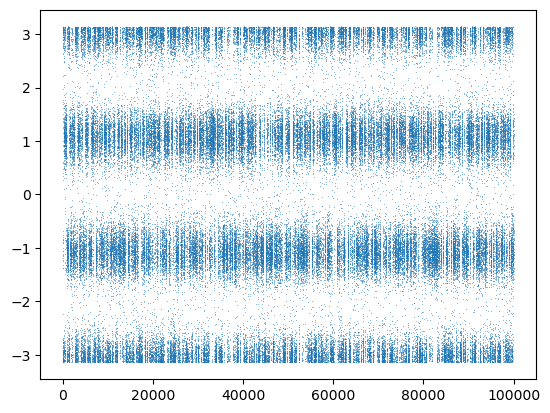

In [123]:
#Compare New Dihedral Distribution HERE
import mdtraj as md
traj_3 = md.load(os.path.join(workdir, "butane_sim_cor3.dcd"), top=PDB_file_name)
CCCC_index=[10,7,4,0]
CCCC_torsion_3=md.compute_dihedrals(traj_3, [CCCC_index])
plt.plot(CCCC_torsion_3,marker='x',markersize=0.1,linewidth=0)

#It looks differently and now the 0 to -2 position is occupied with 0.2 instead of 0.1 frequence, so something happened. The LJ repulsion
#probably forces the bond to exist mostly in the staggered conformation anyway, so in order to equalize the probabilities the torsion has to
#make the other two basins even lower

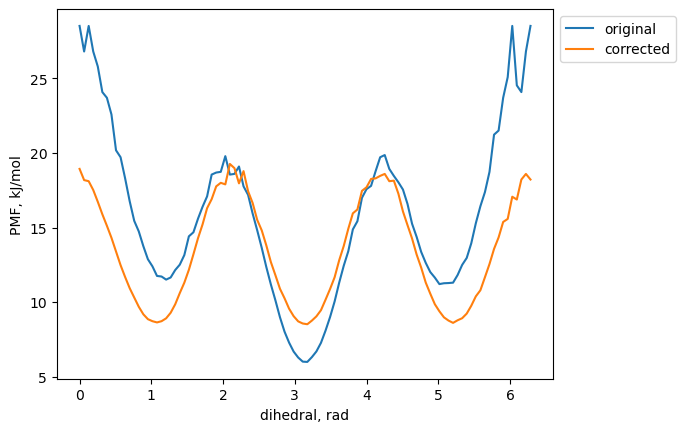

In [126]:
CCCC_dihe_cor3=CCCC_torsion_3[:,0]
CCCC_dihe_absolute_cor3 = np.zeros(len(CCCC_dihe_cor3))
for i in range(0,len(CCCC_dihe_cor3)):
    if(CCCC_dihe_cor3[i] < 0):
        CCCC_dihe_absolute_cor3[i] = CCCC_dihe_cor3[i] + 2*np.pi
    else:
        CCCC_dihe_absolute_cor3[i] = CCCC_dihe_cor3[i]


a_cor3 = np.zeros(100)
b_cor3 = np.zeros(100)
for i in range(0,100):
    a_cor3[i] = len(CCCC_dihe_absolute_cor3[np.where((CCCC_dihe_absolute_cor3 < np.pi*((i+1)/50)) & (CCCC_dihe_absolute_cor3 > np.pi*(i/50)))])
    if(a_cor3[i] == 0):
        b_cor3[i] = 1
    else:
        b_cor3[i] = a_cor3[i]

b_cor3 = b_cor3/np.sum(b_cor3)
PMF_cor3 = -0.008314*298*np.log(b_cor3)
x = np.linspace(0, 2*np.pi, 100)
plt.plot(x, PMF, label = 'original')
plt.plot(x, PMF_cor3, label  = 'corrected')
plt.xlabel('dihedral, rad')
plt.ylabel('PMF, kJ/mol')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


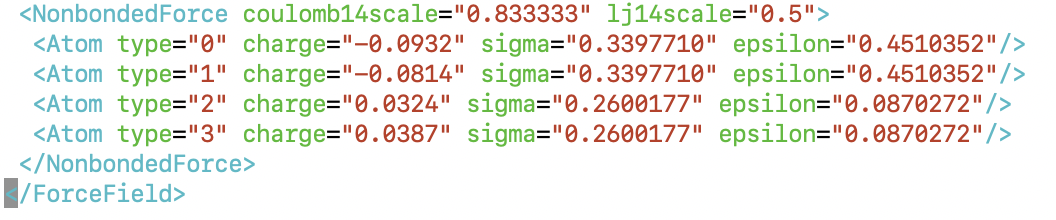




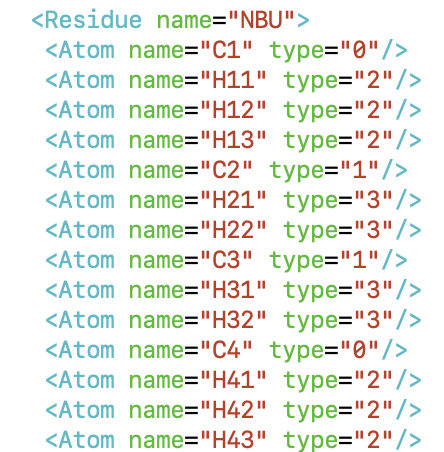

In [ ]:
#Plot LJ and Couloumb Potentionals Here

<function matplotlib.pyplot.show(close=None, block=None)>

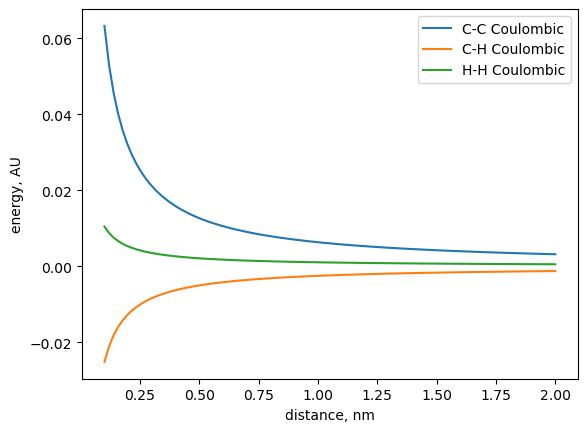

In [93]:
def LJ(r,sigma1,eps1,sigma2,eps2):
    x = (sigma1+sigma2)/(2*r)
    return 0.5*4*np.sqrt(eps1*eps2)*(pow(x,12)-pow(x,6))

def Coul(r,charge1,charge2):
    return 0.833333*charge1*charge2/r

#type combinations 0-1,0-2 and 2-3 were used, they represent C-C, C-H, H-H interactions

x = np.linspace(0.1,2,100)

y_C_C_coul = Coul(x,-0.0932,-0.0814)
y_C_H_coul = Coul(x,-0.0932,0.0324)
y_H_H_coul = Coul(x,0.0324,0.0387)

plt.plot(x, y_C_C_coul, label = 'C-C Coulombic')
plt.plot(x, y_C_H_coul, label = 'C-H Coulombic')
plt.plot(x, y_H_H_coul, label = 'H-H Coulombic')
plt.xlabel('distance, nm')
plt.ylabel('energy, AU')
plt.legend(loc = 'upper right')
plt.show

#Continued below

<function matplotlib.pyplot.show(close=None, block=None)>

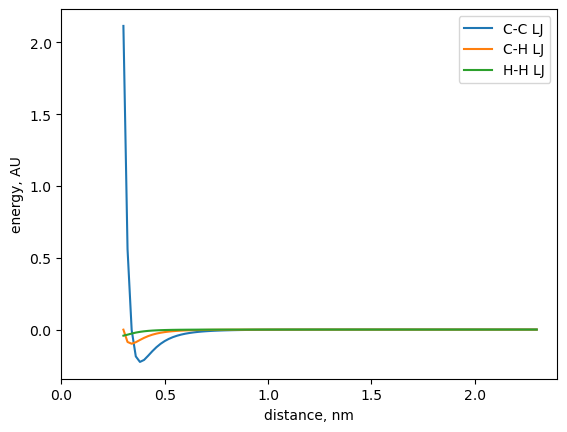

In [96]:
x = np.linspace(0.3,2.3,101)

y_C_C_LJ = LJ(x,0.339771,0.4510352,0.339771,0.4510352)
y_C_H_LJ = LJ(x,0.339771,0.4510352,0.2600177,0.0870272)
y_H_H_LJ = LJ(x,0.2600177,0.0870272,0.2600177,0.0870272)

plt.plot(x, y_C_C_LJ, label = 'C-C LJ')
plt.plot(x, y_C_H_LJ, label = 'C-H LJ')
plt.plot(x, y_H_H_LJ, label = 'H-H LJ')
plt.xlim(0,2.4)
plt.xlabel('distance, nm')
plt.ylabel('energy, AU')
plt.legend(loc = 'upper right')
plt.show